In [1]:
import config

from tqdm import tqdm
import warnings
import os
from hyena_dna.standalone_hyenadna import HyenaDNAModel
import torch
import pickle
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import defaultdict


os.environ['PYTHONWARNINGS'] = 'ignore'
warnings.filterwarnings('ignore')
os.chdir(config.DIR_ROOT)

/Users/nad/miniconda3/envs/mobiraph1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
name_to_embedding = {}
name_to_type = {}
path_to_hyena_embedding = os.path.join(config.DIR_INCEST_MANY, 'hyena_embeddings_and_types.pkl')
with open(path_to_hyena_embedding, "rb") as f:
    data = pickle.load(f)


name_to_embedding = data['embeddings']
name_to_type = data['types']


path_to_filtered = os.path.join(config.DIR_INCEST_MANY, 'repbase_filtered.csv')
df_filtered = pd.read_csv(path_to_filtered)
names = list(df_filtered['name'])


Explained variance ratio: PC1=0.335, PC2=0.278


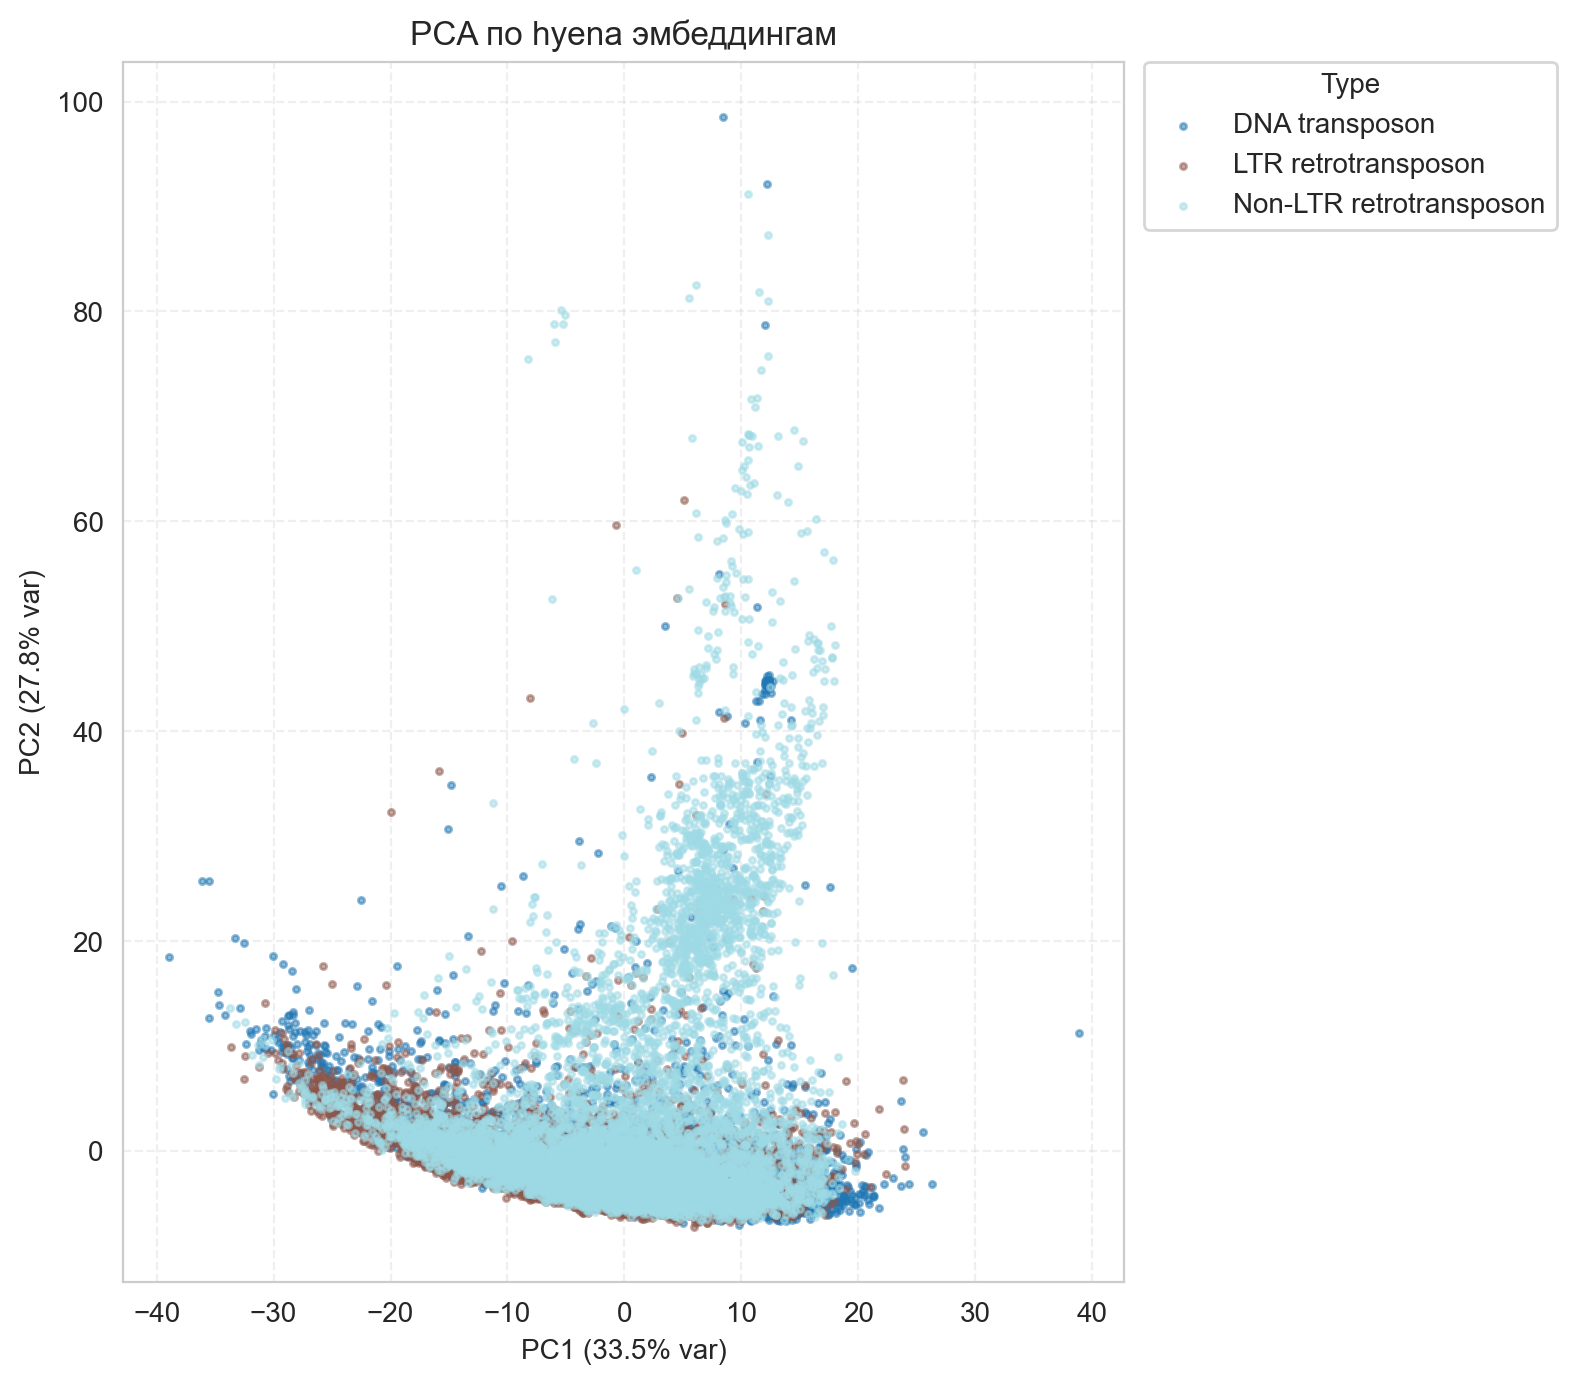

In [9]:
X = np.array([np.asarray(name_to_embedding[n], dtype=float).ravel() for n in names])
y_types = np.array([name_to_type[n] for n in names])

X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=1)
X_pca = pca.fit_transform(X_std)

print(f"Explained variance ratio: PC1={pca.explained_variance_ratio_[0]:.3f}, "
      f"PC2={pca.explained_variance_ratio_[1]:.3f}")

unique_types = sorted(set(y_types))
cmap = plt.get_cmap('tab20') if len(unique_types) <= 20 else plt.get_cmap('hsv')
type_to_color = {t: cmap(i / max(1, len(unique_types)-1)) for i, t in enumerate(unique_types)}

plt.figure(figsize=(8, 7))
for t in unique_types:
    mask = (y_types == t)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                s=5, alpha=0.5, label=t, c=[type_to_color[t]])

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.title('PCA по hyena эмбеддингам')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

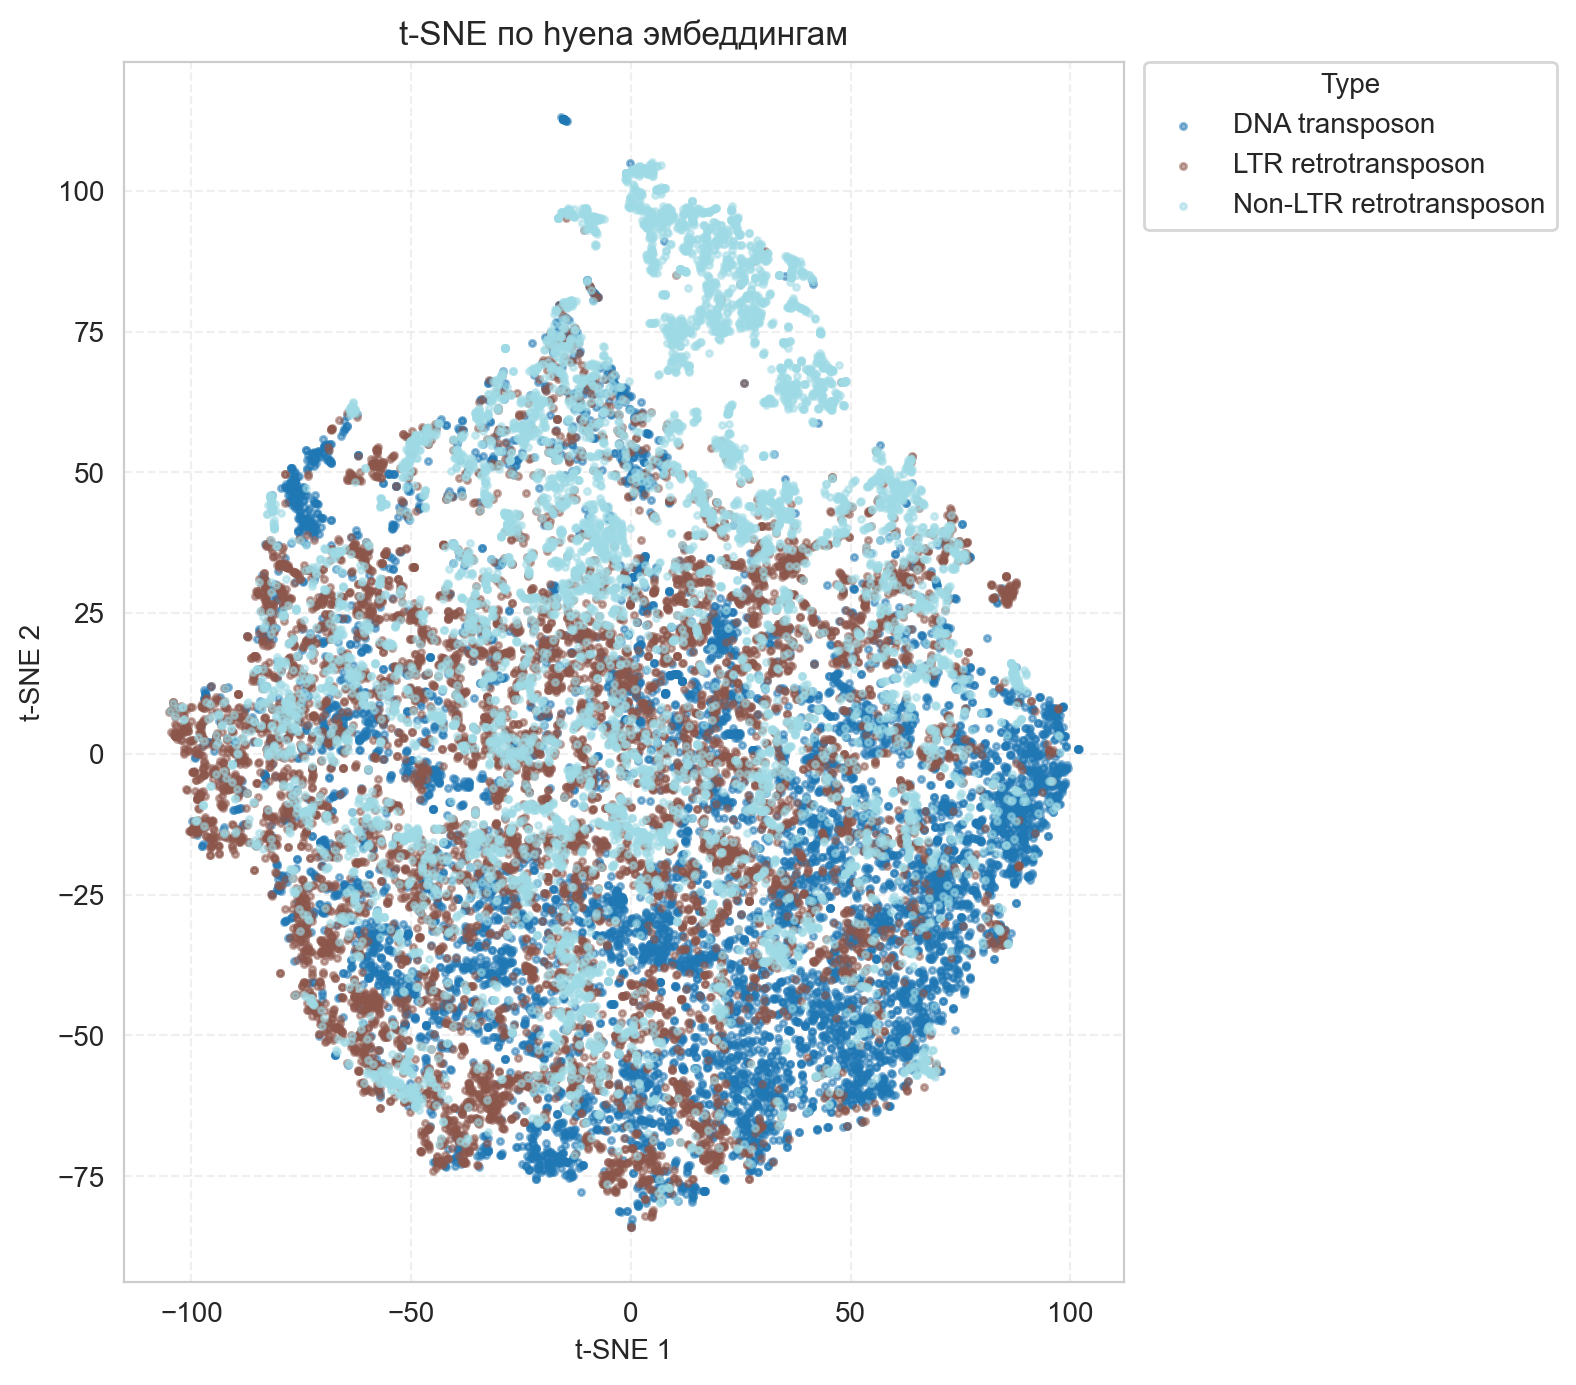

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    n_iter=1000,
    init='pca',
    random_state=42,
    metric='euclidean',
    verbose=0
)

X_tsne = tsne.fit_transform(X_std)

unique_types = sorted(set(y_types))
cmap = plt.get_cmap('tab20') if len(unique_types) <= 20 else plt.get_cmap('hsv')
type_to_color = {t: cmap(i / max(1, len(unique_types)-1)) for i, t in enumerate(unique_types)}

plt.figure(figsize=(8, 7))
for t in unique_types:
    mask = (y_types == t)
    plt.scatter(
        X_tsne[mask, 0], X_tsne[mask, 1],
        s=5, alpha=0.5, label=t, c=[type_to_color[t]]
    )

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE по hyena эмбеддингам')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

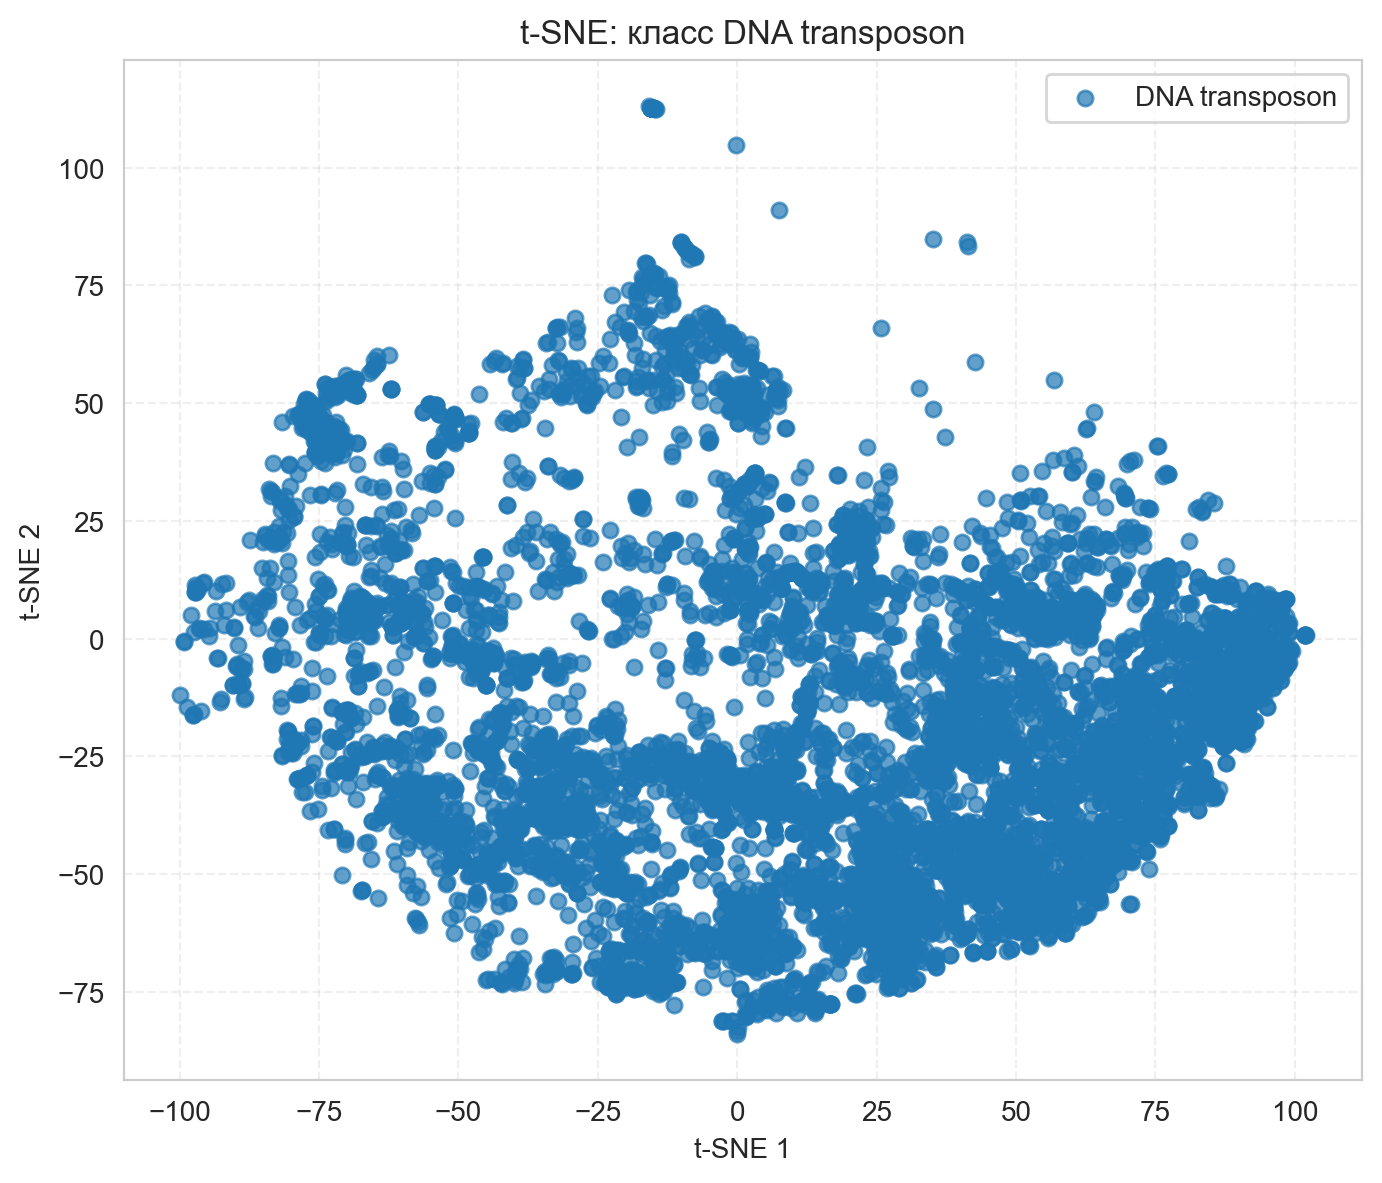

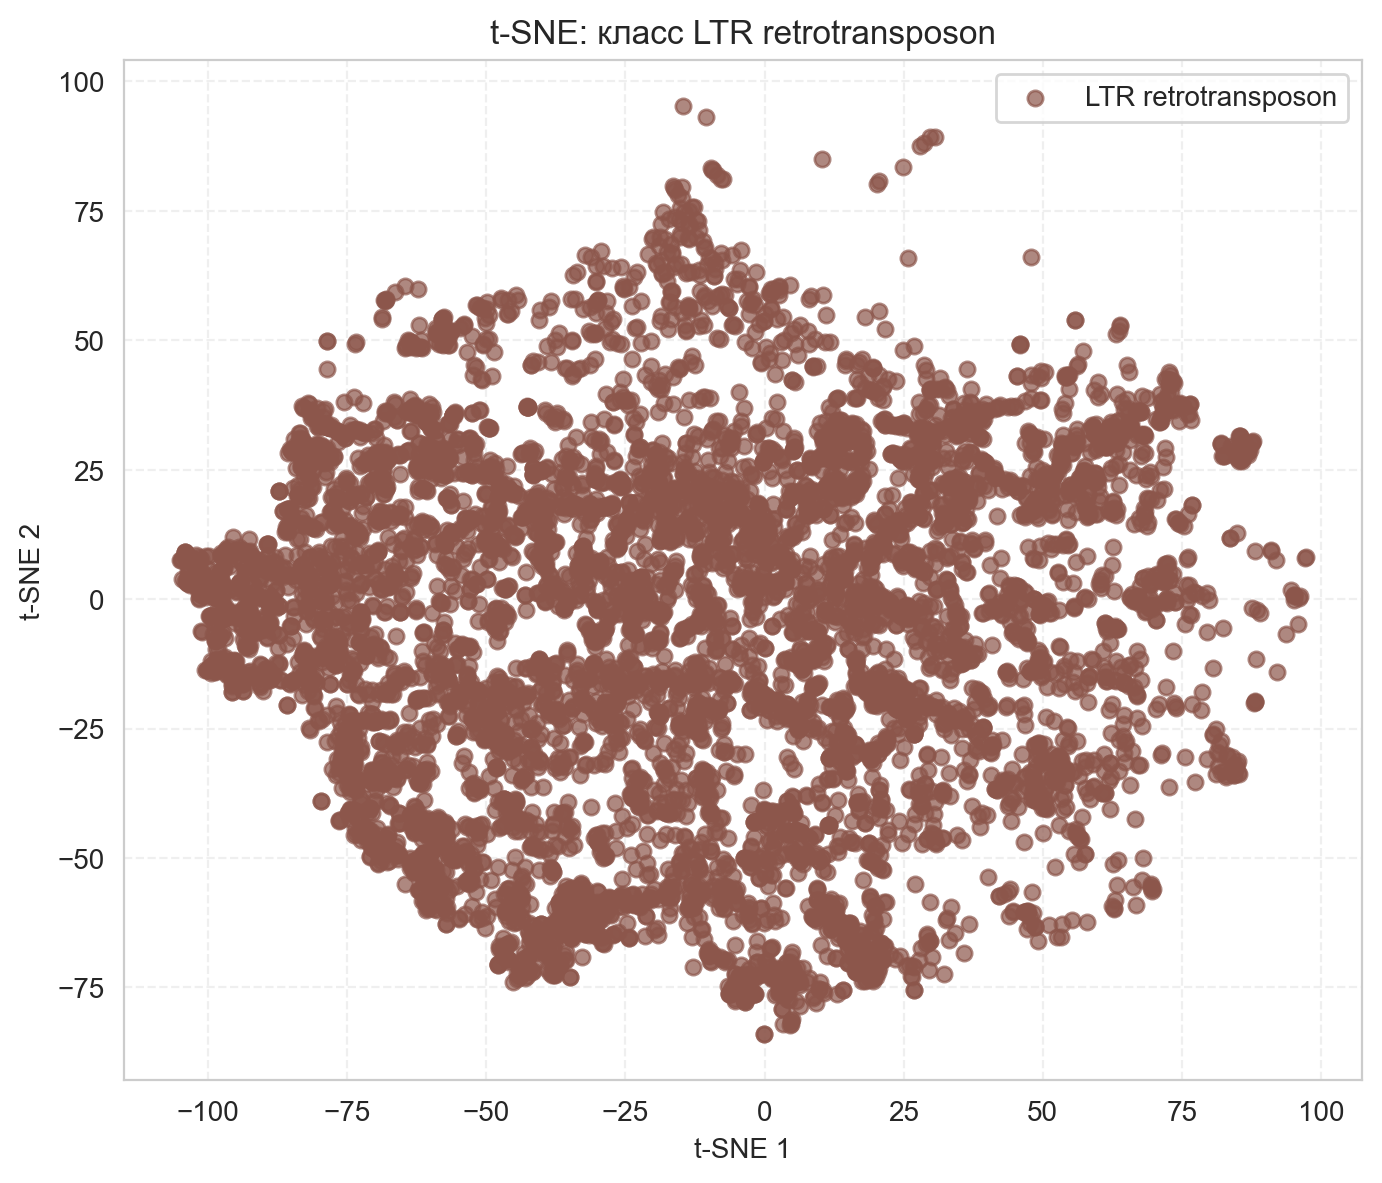

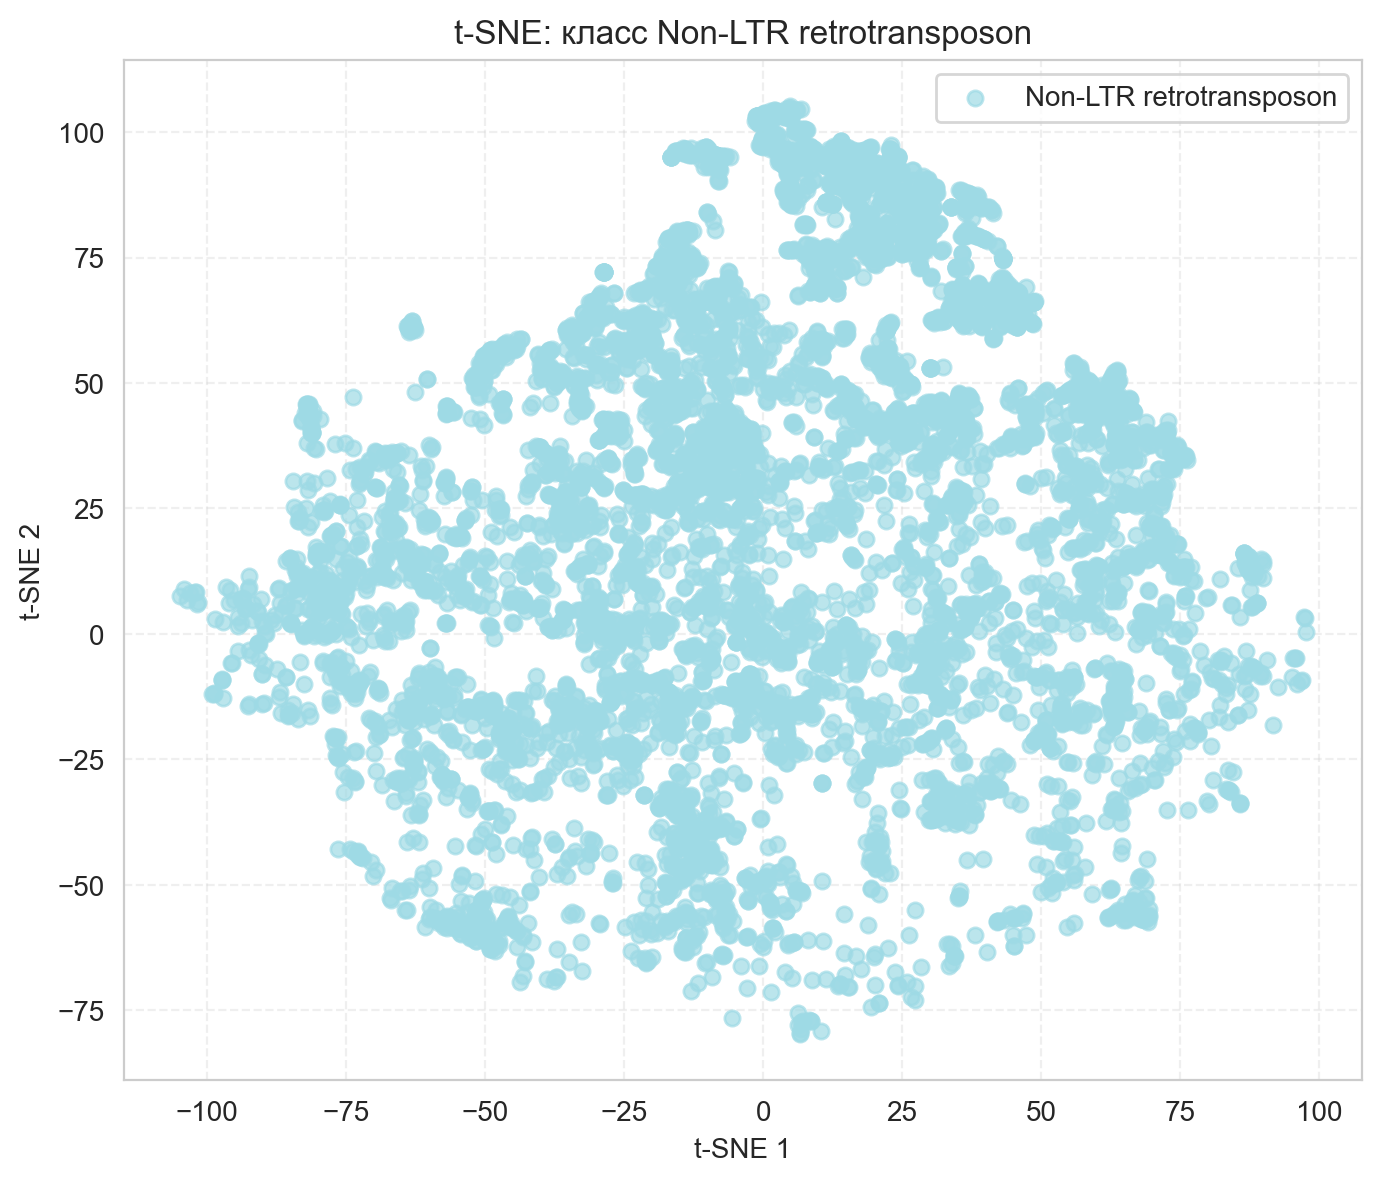

In [6]:
unique_types = sorted(set(y_types))
cmap = plt.get_cmap('tab20') if len(unique_types) <= 20 else plt.get_cmap('hsv')
type_to_color = {t: cmap(i / max(1, len(unique_types)-1)) for i, t in enumerate(unique_types)}

# отдельный график для каждого класса
for t in unique_types:
    mask = (y_types == t)

    plt.figure(figsize=(7, 6))
    plt.scatter(
        X_tsne[mask, 0], X_tsne[mask, 1],
        s=30, alpha=0.7, c=[type_to_color[t]], label=t
    )

    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title(f't-SNE: класс {t}')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

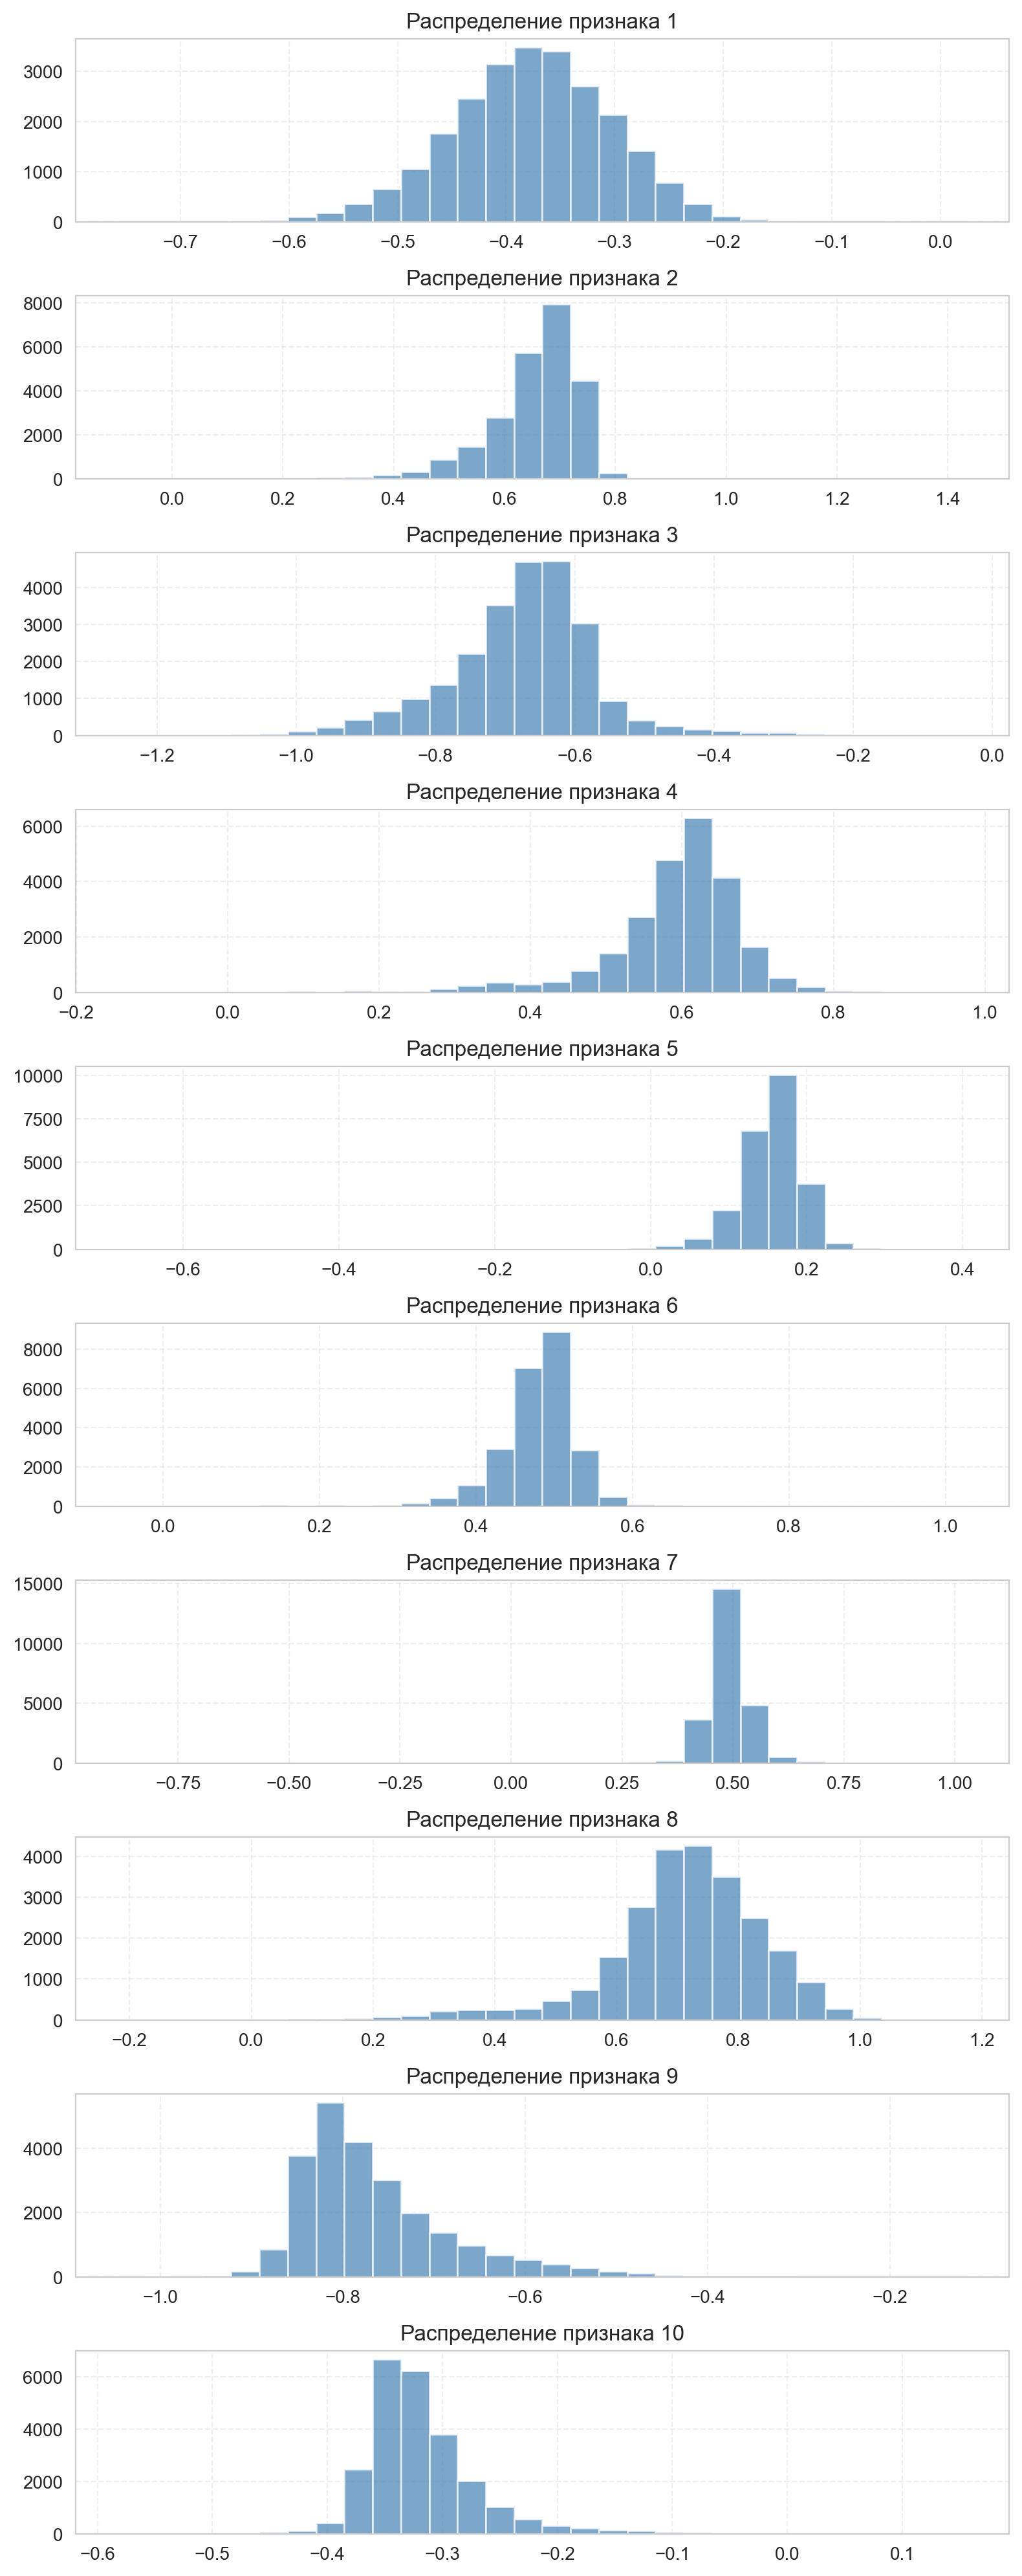

In [7]:
# первые 10 столбцов
n_cols = 10
fig, axes = plt.subplots(n_cols, 1, figsize=(8, 2*n_cols), sharex=False)

for i in range(n_cols):
    axes[i].hist(X[:, i], bins=30, color='steelblue', alpha=0.7)
    axes[i].set_title(f'Распределение признака {i+1}')
    axes[i].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()